In [2]:
import pandas as pd
# Example usage:
# Assume df is your dataframe
#Import our data
log_returns_currencies = pd.read_csv("/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Digital Tools/data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Digital Tools/data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe.columns)

Index(['DATE', 'USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD',
       'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK', 'SP500'],
      dtype='object')


In [3]:
import pandas as pd
#Merges an array of tables into one table, matching by ID
def combine_tables(tables):
    combined_table = tables[0]
    for i in range(1,len(tables)):
        combined_table = pd.merge(combined_table, tables[i], on=['DATE'], suffixes=('', '_df' + str(i)))
   
    # Remove duplicate columns with identical values
    for col in combined_table.columns:
        if '_df' in col:
            prefix, suffix = col.split('_df')
            if combined_table[prefix].equals(combined_table[col]):
                combined_table = combined_table.drop(col, axis=1)
    return combined_table

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def support_vector_machine(dataframe, currencies=None, include_sp500=True,lag=1,train_size=0.75, seed=42, long_only=False):
    """
    Trains a Support Vector Classifier (SVC) on financial data and evaluates its performance.

    This function processes financial data, potentially including S&P 500 information, and applies a Support Vector Classifier to predict binary outcomes. It also calculates the model's accuracy and plots the cumulative returns for comparison.

    Parameters:
    - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally an 'SP500' column.
    - currencies (list of str, optional): A list of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
    - include_sp500 (bool): Determines whether to include the S&P 500 data in the analysis. Defaults to True.
    - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
    - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
    - seed: The seed can be set manually such that the results are reproducible. Default is 42.

    Returns:
    - tuple: A tuple containing a DataFrame of model accuracies and another DataFrame with the cumulative returns for both the 'Long' strategy and the SVC model.
    """
    # Selecting columns based on currencies if provided
    if currencies is not None:
        unavailable_currencies = [currency for currency in currencies if currency not in dataframe.columns]
        if unavailable_currencies:
            available_currencies = ', '.join([col for col in dataframe.columns if col not in ['DATE', 'SP500']])
            unavailable_currencies_str = ', '.join(unavailable_currencies)
            print(f"Sorry, {unavailable_currencies_str} is not an available currency pair. Please choose currency pairs from: {available_currencies}")
            return None

    # Setting up response and regressor variables
    y1 = dataframe.iloc[lag:, -1]  # Assuming the last column is the response variable
    y_dates = dataframe.iloc[lag:, 0]
    X1 = dataframe.iloc[:-lag, 1:-1]  # Excluding Date and response variable

    # Including or excluding SP500 based on the flag
    if include_sp500:
        x1_spx = dataframe.iloc[:-lag, -1]
        X1 = pd.concat([X1, x1_spx], axis=1)

    # Calculating binary response
    y1_exp = np.exp(y1) - 1
    y1_binary = (y1_exp > 0).astype(int)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X1, y1_binary, random_state=seed, shuffle=False, test_size=1-train_size)

    # Setting up dates
    y_test_dates = y_dates[y_test.index[0]-lag:]
    
    # Training the SVC model
    svc_clf = SVC(kernel="rbf", random_state=seed)
    svc_clf.fit(X_train, y_train)
    y_pred_train_svc = svc_clf.predict(X_train)
    y_pred_test_svc = svc_clf.predict(X_test)
    
    # Changing all 0 to -1 for return calculation if long_only is set to false
    if long_only==False:
        y_pred_test_svc[np.where(y_pred_test_svc == 0)] = -1

    # Calculating returns
    y1_ret = y1_exp
    y_bench = y1_ret[y_test.index[0] - lag:]
    y_long = np.cumsum(y_bench)
    y_svc = np.cumsum(y_bench * y_pred_test_svc)

    # Calculating accuracies
    accuracies = pd.DataFrame({
        "Classifiers": ["SVC"],
        "in sample": [accuracy_score(y_train, y_pred_train_svc)],
        "out of sample": [accuracy_score(y_test, y_pred_test_svc)]
    }).set_index('Classifiers')

    test_perform = pd.DataFrame({"SP500": y_long, "SVC": y_svc})

    cumreturns = pd.concat([y_test_dates, test_perform], axis=1)

    return accuracies, cumreturns


In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def randomforest_classifier(dataframe, currencies=None, include_sp500=True, lag=1, train_size=0.75, seed=42, long_only=False, trees=30, max_depth=10, leaves=10):
    """
   Trains a Randomforest Classifier on financial data to predict binary outcomes and evaluates its performance.

   This function processes financial data, which can include currency pairs and optionally S&P 500 data, and applies a Decision Tree Classifier for binary classification. It calculates the model's accuracy and plots cumulative returns for comparison.

   Parameters:
   - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally an 'SP500' column.
   - currencies (list of str, optional): List of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
   - include_sp500 (bool): Determines whether to include the S&P 500 data in the analysis. Defaults to True.
   - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
   - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
   - seed: The seed can be set manually such that the results are reproducible. Default is 42.
   - trees (int): The number of trees in the forest. More trees can lead to a more robust and stable model, but it also comes with increased computational cost. Default is 30.
   - max_depth (int): The maximum depth of one decision tree in the forest. Helps to control the complexity of the model. Defaults to 10.
   - leaves (int): The maximum number of terminal nodes / leaves in one tree. Helps to control the complexity of the model. Defaults to 10.

   Returns:
   - tuple: A tuple containing a DataFrame of model accuracies and another DataFrame with the cumulative returns for both the 'Long' strategy and the Decision Tree Classifier model.
   """

    # Selecting columns based on currencies if provided
    if currencies is not None:
        unavailable_currencies = [currency for currency in currencies if currency not in dataframe.columns]
        if unavailable_currencies:
            available_currencies = ', '.join([col for col in dataframe.columns if col not in ['DATE', 'SP500']])
            unavailable_currencies_str = ', '.join(unavailable_currencies)
            print(
                f"Sorry, {unavailable_currencies_str} is not an available currency pair. Please choose currency pairs from: {available_currencies}")
            return None

    # Setting up response and regressor variables
    y1 = dataframe.iloc[lag:, -1]  # Assuming the last column is the response variable
    y_dates = dataframe.iloc[lag:, 0]
    X1 = dataframe.iloc[:-lag, 1:-1]  # Excluding Date and response variable

    # Including or excluding SP500 based on the flag
    if include_sp500:
        x1_spx = dataframe.iloc[:-lag, -1]
        X1 = pd.concat([X1, x1_spx], axis=1)

    # Calculating binary response
    y1_exp = np.exp(y1) - 1
    y1_binary = (y1_exp > 0).astype(int)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X1, y1_binary, random_state=seed, shuffle=False,
                                                        test_size=1 - train_size)

    # Setting up dates
    y_test_dates = y_dates[y_test.index[0] - lag:]

    # Training the Randomforest Classifier
    randomforest_clf = RandomForestClassifier(n_estimators=trees, random_state=seed, max_depth=max_depth, max_leaf_nodes=leaves)
    randomforest_clf.fit(X_train, y_train)
    y_pred_train_rfc = randomforest_clf.predict(X_train)
    y_pred_test_rfc = randomforest_clf.predict(X_test)

    # Changing all 0 to -1 for return calculation if long_only is set to false
    if long_only==False:
        y_pred_test_rfc[np.where(y_pred_test_rfc == 0)] = -1

    # Calculating returns
    y1_ret = y1_exp
    y_bench = y1_ret[y_test.index[0] - lag:]
    y_long = np.cumsum(y_bench)
    y_rfc = np.cumsum(y_bench * y_pred_test_rfc)

    # Calculating accuracies
    accuracies = pd.DataFrame({
        "Classifiers": ["RFC"],
        "in sample": [accuracy_score(y_train, y_pred_train_rfc)],
        "out of sample": [accuracy_score(y_test, y_pred_test_rfc)]
    }).set_index('Classifiers')

    test_perform = pd.DataFrame({"SP500": y_long, "RFC": y_rfc})
    
    cumreturns = pd.concat([y_test_dates, test_perform], axis=1)

    return accuracies, cumreturns

In [6]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def decision_tree_classifier(dataframe, currencies=None, include_sp500=True,lag=1,train_size=0.75, seed=42,long_only=False,max_depth=10):
    """
    Trains a Decision Tree Classifier on financial data to predict binary outcomes and evaluates its performance.

    This function processes financial data, which can include currency pairs and optionally S&P 500 data, and applies a Decision Tree Classifier for binary classification. It calculates the model's accuracy and plots cumulative returns for comparison.

    Parameters:
    - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally an 'SP500' column.
    - currencies (list of str, optional): List of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
    - include_sp500 (bool): Determines whether to include the S&P 500 data in the analysis. Defaults to True.
    - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
    - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
    - seed: The seed can be set manually such that the results are reproducible. Default is 42.
    - max_depth (int): The maximum depth of the decision tree. Helps to control the complexity of the model. Defaults to 10.

    Returns:
    - tuple: A tuple containing a DataFrame of model accuracies and another DataFrame with the cumulative returns for both the 'Long' strategy and the Decision Tree Classifier model.
    """
    
    # Selecting columns based on currencies if provided.
    if currencies is not None:
        unavailable_currencies = [currency for currency in currencies if currency not in dataframe.columns]
        if unavailable_currencies:
            available_currencies = ', '.join([col for col in dataframe.columns if col not in ['DATE', 'SP500']])
            unavailable_currencies_str = ', '.join(unavailable_currencies)
            print(f"Sorry, {unavailable_currencies_str} is not an available currency pair. Please choose currency pairs from: {available_currencies}")
            return None
    
    # Setting up response and regressor variables
    y1 = dataframe.iloc[lag:, -1]  # Assuming the last column is the response variable
    y_dates = dataframe.iloc[lag:, 0]
    X1 = dataframe.iloc[:-lag, 1:-1]  # Excluding Date and response variable

    # Including or excluding SP500 based on the flag
    if include_sp500:
        x1_spx = dataframe.iloc[:-lag, -1]
        X1 = pd.concat([X1, x1_spx], axis=1)

    # Calculating binary response
    y1_exp = np.exp(y1) - 1
    y1_binary = (y1_exp > 0).astype(int)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X1, y1_binary, random_state=seed, shuffle=False, test_size=1-train_size)

    # Setting up dates
    y_test_dates = y_dates[y_test.index[0]-lag:]
    
    # Training the Decision Tree Classifier
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=seed)
    tree_clf.fit(X_train, y_train)
    y_pred_train_dtc = tree_clf.predict(X_train)
    y_pred_test_dtc = tree_clf.predict(X_test)

    # Changing all 0 to -1 for return calculation if long_only is set to false
    if long_only==False:
        y_pred_test_dtc[np.where(y_pred_test_dtc == 0)] = -1

    # Calculating returns
    y1_ret = y1_exp
    y_bench = y1_ret[y_test.index[0]-lag:]
    y_long = np.cumsum(y_bench)
    y_dtc = np.cumsum(y_bench * y_pred_test_dtc)

    # Calculating accuracies
    accuracies = pd.DataFrame({
        "Classifiers": ["DTC"],
        "in sample": [accuracy_score(y_train, y_pred_train_dtc)],
        "out of sample": [accuracy_score(y_test, y_pred_test_dtc)]
    }).set_index('Classifiers')

    test_perform = pd.DataFrame({"SP500": y_long, "DTC": y_dtc})

    cumreturns = pd.concat([y_test_dates, test_perform], axis=1)

    return accuracies, cumreturns

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
def plot_results(dataframe, include_sp500):
    # Plotting
    plt.figure(figsize=(14, 6))
    cols = dataframe.shape[1]
    # Set the Seaborn color palette
    sns.set_palette("colorblind")
    for i in range(1, cols):
        plt.plot(dataframe["DATE"], dataframe.iloc[:,i], label= dataframe.columns[i])

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title("Financial Performance Prediction" + (" with " if include_sp500 else " without ") + "S&P500")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # Add grid
    plt.grid(True)
    plt.show()

In [19]:
def run_simulations(dataframe, currencies, include_sp500, lag, train_size, long_only, num_simulations):
    # Initialize lists to store results
    svm_results_list = pd.DataFrame()
    rf_results_list = pd.DataFrame()
    dt_results_list = pd.DataFrame()

    # Run simulations for each model
    for i in range(num_simulations):
        seed = np.random.randint(0, 10000)  # Random seed for each simulation

        # SVM model
        _, svm_results = support_vector_machine(dataframe, currencies, include_sp500, lag, train_size, seed, long_only)
        if i == 0:
            svm_dates = svm_results['DATE']
            svm_results_list = pd.concat([svm_results_list, svm_dates], axis=1)
        svm_relevant_column = svm_results.iloc[:, -1].rename(f'SVM Simulation {i+1}')
        svm_results_list = pd.concat([svm_results_list, svm_relevant_column], axis=1)

        # Random Forest model
        _, rf_results = randomforest_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only)
        if i == 0:
            rf_dates = rf_results['DATE']
            rf_results_list = pd.concat([rf_results_list, rf_dates], axis=1)
        rf_relevant_column = rf_results.iloc[:, -1].rename(f'RF Simulation {i+1}')
        rf_results_list = pd.concat([rf_results_list, rf_relevant_column], axis=1)

        # Decision Tree model
        _, dt_results = decision_tree_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only, max_depth=100)
        if i == 0:
            dt_dates = dt_results['DATE']
            dt_results_list = pd.concat([dt_results_list, dt_dates], axis=1)
        dt_relevant_column = dt_results.iloc[:, -1].rename(f'DT Simulation {i+1}')
        dt_results_list = pd.concat([dt_results_list, dt_relevant_column], axis=1)
    
    svm_results_list['DATE'] = pd.to_datetime(svm_results_list['DATE'], format='%Y-%m-%d')
    rf_results_list['DATE'] = pd.to_datetime(rf_results_list['DATE'], format='%Y-%m-%d')
    dt_results_list['DATE'] = pd.to_datetime(dt_results_list['DATE'], format='%Y-%m-%d')
    
    return svm_results_list, rf_results_list, dt_results_list

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_simulation_results(svm_results, rf_results, dt_results):
 

    # Calculate rf quantiles
    series = rf_results.iloc[-1:,1:].iloc[0]
    median_column = series.sub(series.median()).abs().idxmin()
    lq_column = series.sub(series.quantile(0.75)).abs().idxmin()
    hq_column = series.sub(series.quantile(0.25)).abs().idxmin()
    rf_ranges = rf_results[['DATE',lq_column, median_column, hq_column]]
    rf_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)
    
     # Calculate dt quantiles
    series = dt_results.iloc[-1:,1:].iloc[0]
    median_column = series.sub(series.median()).abs().idxmin()
    lq_column = series.sub(series.quantile(0.75)).abs().idxmin()
    hq_column = series.sub(series.quantile(0.25)).abs().idxmin()
    dt_ranges = dt_results[['DATE',lq_column, median_column, hq_column]]
    dt_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)
    
    
    # Plot for SVM simulations
    plt.figure(figsize=(14, 6))
    cols = svm_results.shape[1]
    # Set the Seaborn color palette
    sns.set_palette("colorblind")
    for i in range(1, cols):
        plt.plot(svm_results["DATE"], svm_results.iloc[:,i],alpha=0.4)

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title("SVM Financial Performance Prediction" + (" with " if include_sp500 else " without ") + "S&P500")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # Add grid
    plt.grid(True)
    plt.show()

    # Plot for Random Forest simulations
    plt.figure(figsize=(14, 6))
    cols = rf_results.shape[1]
    # Set the Seaborn color palette
    sns.set_palette("colorblind")
    for i in range(1, cols):
        plt.plot(rf_results["DATE"], rf_results.iloc[:,i],color='grey', alpha=0.4)
    plt.plot(rf_results["DATE"], rf_ranges['25% quantile'], label='25% Quantile', color='blue', linewidth=2)
    plt.plot(rf_results["DATE"], rf_ranges['median'], label='Median', color='red', linewidth=2)
    plt.plot(rf_results["DATE"], rf_ranges['75% quantile'], label='75% Quantile', color='blue', linewidth=2)
    plt.fill_between(rf_results["DATE"], rf_ranges['25% quantile'], rf_ranges['75% quantile'], color='green', alpha=0.2)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title("Random Forest Financial Performance Prediction" + (" with " if include_sp500 else " without ") + "S&P500")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # Add grid
    plt.grid(True)
    plt.show()

    # Plot for Decision Tree simulations
    plt.figure(figsize=(14, 6))
    cols = dt_results.shape[1]
    # Set the Seaborn color palette
    sns.set_palette("colorblind")
    for i in range(1, cols):
        plt.plot(dt_results["DATE"], dt_results.iloc[:,i],color='grey', alpha=0.4)
    plt.plot(dt_results["DATE"], dt_ranges['25% quantile'], label='25% Quantile', color='blue', linewidth=2)
    plt.plot(dt_results["DATE"], dt_ranges['75% quantile'], label='75% Quantile', color='blue', linewidth=2)
    plt.fill_between(dt_results["DATE"], dt_ranges['25% quantile'], dt_ranges['75% quantile'], color='green', alpha=0.2)
    plt.plot(dt_results["DATE"], dt_ranges['median'], label='Median', color='red', linewidth=2)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title("Decision Tree Financial Performance Prediction" + (" with " if include_sp500 else " without ") + "S&P500")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # Add grid
    plt.grid(True)
    plt.show()

<ipython-input-22-97e3186762c2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)
<ipython-input-22-97e3186762c2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)
No handles with labels found to put in legend.


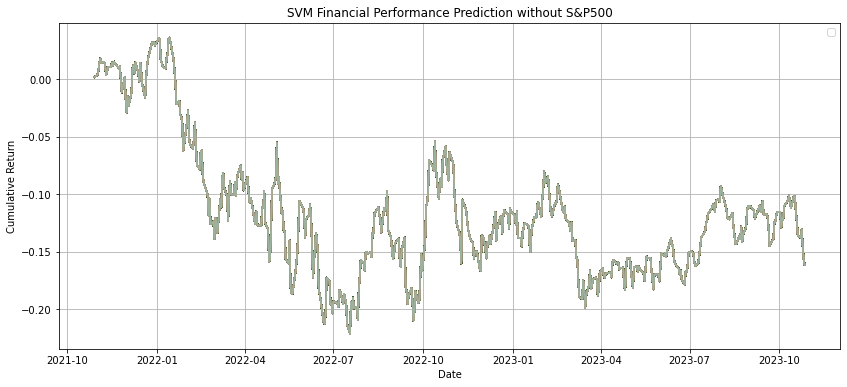

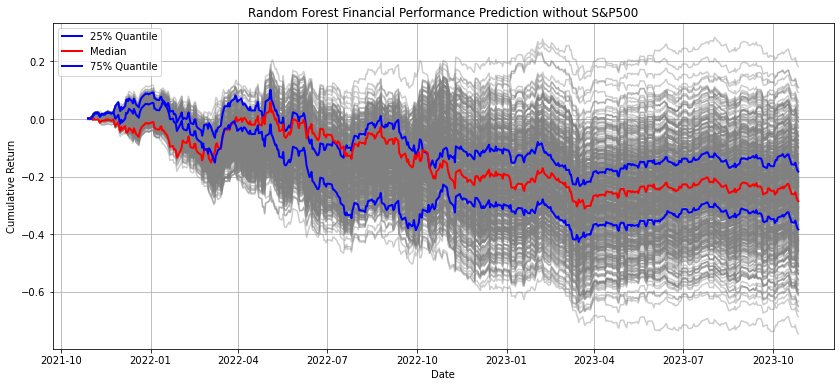

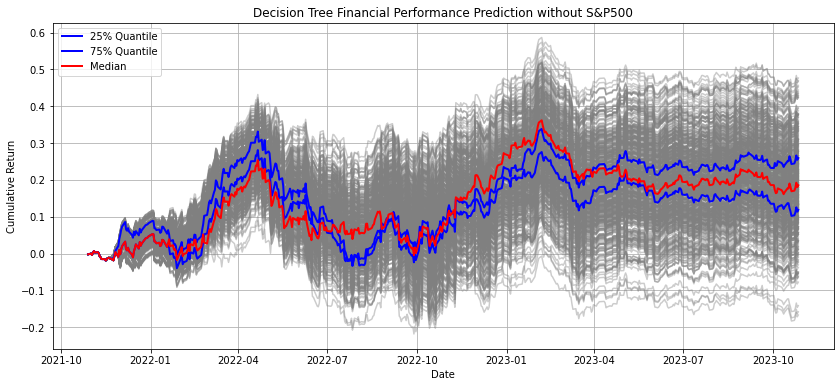

In [24]:
# Define your parameters
currencies = ['USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD', 
              'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK']  # Example currency pairs
include_sp500 = False  # Whether to include S&P 500 data
num_simulations = 500
lag = 1  # Number of days lag for models
train_size = 0.8  # Proportion of the dataset used for training
long_only = False  # Whether the strategy should be long only

# Make sure the dataframe and other parameters (currencies, include_sp500, etc.) are already defined
svm_results, rf_results, dt_results = run_simulations(dataframe, currencies, include_sp500, lag, train_size, long_only, num_simulations)

# Step 2: Plot the simulation results
plot_simulation_results(svm_results, rf_results, dt_results)